# El seductor canto de las sirenas

## Idea general

Las dos clases están balanceadas, `50%` de cada una, usaré `80%`de los registros para encontrar el mejor modelo predictivo, y el resto para obtener su error de generalización, usaré el `f1 score` para evaluar las predicciones, haciendo la separación estratificada para que train y test tengan la misma proporción de cada clase. 

Unas gráficas exploratorias me ayudarón a determinar la mejor ingeniería de variables, sencilla en esté caso. Estandarizaré las variables, y añadire las interacciones entré las variables. Probaré dos entradas a los modelos, una con solo la estandarización, la segunda incluirá las interacciones; en esté caso probé una **regresión logística** y una **máquina de vectores de soporte**.

# Resultados

Las 4 aproximaciones obtuvierón un desempeño perfecto en entrenamiento, elegí la más sencilla: la regresión logística usando las variables estandarizadas, está obtuvo un desempeño perfecto en test, `f1 score = 1`, esté mismo modelo clasificó a los nuevos individuos, guardandolos en el archivo **sirenas_endemicas_y_sirenas_migrantes_con_predicciones.csv**. 

Esperaría que el modelo no tuvierá un desempeño perfecto en el mundo real, pero dado que usé una metodología sólida confió en las predicciones.

In [1]:
# dependencias
import numpy  as np
import pandas as pd
from   seaborn                 import scatterplot, pairplot
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.preprocessing   import StandardScaler, PolynomialFeatures, OneHotEncoder
from   sklearn.linear_model    import LogisticRegression
from   sklearn.svm             import LinearSVC
from   sklearn.metrics         import make_scorer, f1_score

In [2]:
# ubicacion de las entradas
path_sirenas_historico    = 'work/datasets/sirenas_endemicas_y_sirenas_migrantes_historico.csv'
path_sirenas_nuevas       = 'work/datasets/sirenas_endemicas_y_sirenas_migrantes.csv'
# ubicación de las salidas
path_sirenas_predicciones = 'work/datasets/sirenas_endemicas_y_sirenas_migrantes_con_predicciones.csv'

In [3]:
# cargado de datos
sirenas_historico = pd.read_csv(path_sirenas_historico)
sirenas_nuevas    = pd.read_csv(path_sirenas_nuevas)

## Exploración inicial

In [4]:
# primeros y últimos registros
print(sirenas_historico.head())
print(sirenas_historico.tail())

    v1   v2   v3   v4          especie
0  4.3  3.0  1.1  0.1  sirena_migrante
1  4.8  3.0  1.4  0.1  sirena_migrante
2  4.9  3.1  1.5  0.1  sirena_migrante
3  4.9  3.1  1.5  0.1  sirena_migrante
4  4.9  3.1  1.5  0.1  sirena_migrante
     v1   v2   v3   v4          especie
95  6.3  3.4  5.6  2.4  sirena_endemica
96  6.7  3.1  5.6  2.4  sirena_endemica
97  6.7  3.3  5.7  2.5  sirena_endemica
98  6.3  3.3  6.0  2.5  sirena_endemica
99  7.2  3.6  6.1  2.5  sirena_endemica


In [5]:
# estadística descriptiva
sirenas_historico.describe()

,v1,v2,v3,v4
count,100.000000,100.000000,100.000000,100.000000
mean,5.797000,3.196000,3.508000,1.135000
std,0.945319,0.416071,2.094229,0.919198
min,4.300000,2.200000,1.000000,0.100000
25%,5.000000,3.000000,1.500000,0.200000
50%,5.700000,3.150000,3.200000,1.000000
75%,6.500000,3.400000,5.525000,2.000000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# sirenas por especie
sirenas_historico.groupby(['especie']).agg(['count'])

,v1,v2,v3,v4
,count,count,count,count
especie,,,,
sirena_endemica,50,50,50,50
sirena_migrante,50,50,50,50


La cantidad de sirenas esta perfectamente balanceada.

## Separación en train and test
Tenemos 100 observaciones, las clases están balanceadas, ambas tienen `50%` de las observaciones; usaré el `80%` de las observaciones para encontrar el mejor modelo predictivo, y el `20%` restante para medir su desempeño esperado en el mundo real.

In [7]:
## llevo los datos a un formato para scikit-learn
# definición de las columnas
columnas_predictoras = ['v1', 'v2', 'v3', 'v4']
columna_objetivo     = ['especie']
# separación 
predictores = sirenas_historico[columnas_predictoras]
objetivo    = sirenas_historico[columna_objetivo]
# train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(predictores, objetivo, random_state = 42, test_size = 0.2, shuffle = True, stratify = objetivo)

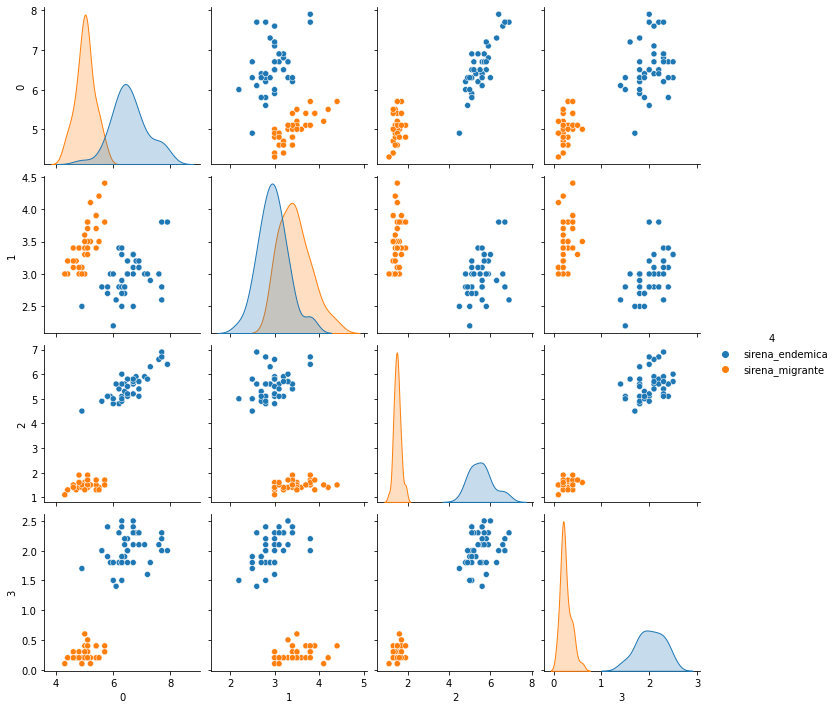

In [8]:
# gráficas de dispersión del conjunto de entrenamiento
pairplot(pd.concat([x_train, y_train], axis = 1, ignore_index = True), hue = 4)

##
Las gráficas de dispersión sugieren que las dos clases de sirenas, endemicas y migrantes, son linealmente separables.

## Ingeniería de variables
Estandarizaré las variables, luego añadiré las interacciones entre las variables; para la variable objetivo mapearé las sirenas endemicas a `0` y las migrantes a `1`, el formato esperado por scikit-learn (y las mayoria de las librerias de aprendizaje automático).

Probaré dos versiones de los datos preparados, una con solo las variables estandarizadas, y otra con las interacciones añadidas.

In [9]:
# estandarización: después de esta transformación las variables tendrán promedio 0 y desviación estandar 1
# ajuste
estandarizador = StandardScaler(with_mean = True, with_std = True).fit(x_train)
# transformación
x_train_estandarizados = estandarizador.transform(x_train)

In [10]:
# añado las interacciones
# ajuste
poly = PolynomialFeatures(interaction_only = True, include_bias = False).fit(x_train_estandarizados)
# transformación
x_train_con_interacciones = poly.transform(x_train_estandarizados)

In [11]:
# preparación del la variable objetivo, espera 0 o 1, mapearé las endémicas a 0  y las migrantes a 1
codificacion_objetivo = {'especie': {'sirena_endemica': 0, 'sirena_migrante': 1}}
#
y_train_encoded       = y_train.replace(codificacion_objetivo)

## Modelado
Tenemos un problema de clasificación binaria, con ambas clases perfectamente balanceadas (50% de cada una). Probaré una **regresión logística**, y una **máquina de vectores de soporte (support-vector machine)**; además, usaré validación cruzada y exploraré el espacio de los modelos.  

Dado qué las clases están balanceadas, usaré el **f1 score**, la media armónica entre precisión y exhaustividad, como métrica para determinar el mejor modelo prédictivo (más es mejor); en algunas circunstancias la precisión o la exhaustividad tendrían más sentido, e.g. una especie es más agresiva hacía la otra, pero dado la información disponible el **f1 score** es una buena opción.

In [12]:
# evaluador para la exploración del espacio de modelos
scorer_f1  = make_scorer(f1_score)

### Regresión logística

In [13]:
# hiperparametros a explorar
parameters_logit = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.1, 0.5, 1, 5, 10]}

In [14]:
# versión sin interacciones
# declaro el modelo
modelo_logit_estandarizado = GridSearchCV(LogisticRegression(solver = 'saga', random_state = 42, n_jobs = 1), param_grid = parameters_logit, n_jobs = 4, cv = 4, scoring = scorer_f1)
# ajusto el modelo
modelo_logit_estandarizado.fit(X = x_train_estandarizados, y = y_train_encoded)
# extraigo el mejor modelo
modelo_logit_estandarizado_mejor = modelo_logit_estandarizado.best_estimator_
# vistazo rápido
print(modelo_logit_estandarizado_mejor)
print(modelo_logit_estandarizado.best_score_)

LogisticRegression(C=0.1, n_jobs=1, penalty='l1', random_state=42,
                   solver='saga')
1.0
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [15]:
# regresión logística con interacciones
# declaro el modelo
modelo_logit_interacciones = GridSearchCV(LogisticRegression(solver = 'saga', random_state = 42, n_jobs = 1), param_grid = parameters_logit, n_jobs = 4, cv = 4, scoring = scorer_f1)
# ajusto el modelo
modelo_logit_interacciones.fit(X = x_train_con_interacciones, y = y_train_encoded)
# extraigo el mejor modelo
modelo_logit_interacciones_mejor = modelo_logit_interacciones.best_estimator_
# vistazo rápido
print(modelo_logit_interacciones_mejor)
print(modelo_logit_interacciones.best_score_)

LogisticRegression(C=0.1, n_jobs=1, penalty='l1', random_state=42,
                   solver='saga')
1.0
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Máquina de vectores de soporte (support-vector machine)

In [16]:
# hiperparametros a probar
parameters_svm = {'penalty': ['l1', 'l2'], 'C': [0.1, .5, 1, 5, 10]}

In [17]:
# svm sin interacciones
# declaro el modelo
modelo_svm_estandarizado = GridSearchCV(LinearSVC(random_state = 42), param_grid = parameters_svm, n_jobs = 4, cv = 4, scoring = scorer_f1)
# ajusto el modelo
modelo_svm_estandarizado.fit(X = x_train_estandarizados, y = y_train_encoded)
# extraigo el mejor modelo
modelo_svm_estandarizado_mejor = modelo_svm_estandarizado.best_estimator_ 
# vistazo
print(modelo_svm_estandarizado_mejor)
print(modelo_svm_estandarizado.best_score_)

LinearSVC(C=0.1, random_state=42)
1.0
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [18]:
# svm con interacciones
# declaro el modelo
modelo_svm_interacciones = GridSearchCV(LinearSVC(random_state = 42), param_grid = parameters_svm, n_jobs = 4, cv = 4, scoring = scorer_f1)
# ajusto el modelo
modelo_svm_interacciones.fit(X = x_train_con_interacciones, y = y_train_encoded)
# extraigo el mejor modelo
modelo_svm_interacciones_mejor = modelo_svm_interacciones.best_estimator_ 
# vistazo
print(modelo_svm_interacciones_mejor)
print(modelo_svm_interacciones.best_score_)

LinearSVC(C=0.1, random_state=42)
1.0
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Selección del modelo

De las gráficas de dispersión intuí que las dos clases eran linealmente separables, las 4 combinaciones, 2 modelos y 2 entradas diferentes, que probé lograron un desempeño perfecto, `f1 score = 1`; elegiré la aproximación más sencilla: la regressión logística con la entrada sin interacciones.

## Evaluación del mejor modelo 
Obtendré el error de generalización, usando el mejor modelo predictivo en los datos de test, y comparando esto con los valores reales

In [19]:
# preparo la entrada para la predicción
# estandarización
x_test_estandarizados = estandarizador.transform(x_test)

In [20]:
# predicción
prediccion = modelo_logit_estandarizado_mejor.predict(x_test_estandarizados)

In [21]:
# obtengo el error de generalización
y_test_encoded = y_test.replace(codificacion_objetivo).reset_index(drop = True)
#
error_generalizacion_f1_score = f1_score(y_test_encoded, prediccion)
# print
error_generalizacion_f1_score

1.0

¡¡Las predicciones son perfectas!!

Hay al menos dos opciones, una es que las dos especies de sirenas son linealmente separanles, o que sobreajustamos los modelos; seguí una metodología sólida, así que confiaré en el modelo predictivo.

## Clasificación de individuos

In [22]:
# transformo la entrada para la prediccion
sirenas_nuevas_estandarizadas = estandarizador.transform(sirenas_nuevas[columnas_predictoras])

In [23]:
# uso el mejor modelo para predecir
predicciones_sirenas_nuevas = modelo_logit_estandarizado_mejor.predict(sirenas_nuevas_estandarizadas)
# vistazo
print(predicciones_sirenas_nuevas)

[0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0
 1 1]


## Salida
Añadiré las predicciones a la tabla.

In [24]:
# copio el dataframe
df_salida = sirenas_nuevas.copy()
# añado las predicciones
df_salida['especie'] = predicciones_sirenas_nuevas
# vistazo
print(df_salida)

     v1   v2   v3   v4  especie
0   6.6  2.3  4.1  1.5        0
1   4.5  2.9  2.4  1.6        1
2   5.7  2.3  6.3  0.4        0
3   5.1  3.3  1.7  2.1        1
4   7.0  4.0  1.0  1.6        1
5   7.6  2.3  2.1  1.2        1
6   4.7  3.3  5.6  1.8        0
7   4.9  3.8  2.0  2.4        1
8   7.4  3.0  4.3  0.8        0
9   6.0  3.0  2.5  2.1        1
10  6.2  4.1  6.3  2.0        0
11  7.7  2.3  2.5  0.9        1
12  6.4  4.0  6.8  0.8        0
13  5.7  4.4  5.5  0.9        0
14  4.3  4.0  4.3  0.7        0
15  7.7  3.6  6.2  2.1        0
16  6.3  3.7  1.5  2.2        1
17  5.6  3.9  4.5  2.3        0
18  6.3  4.0  6.7  0.3        0
19  5.6  3.1  2.2  1.4        1
20  6.3  2.3  3.7  2.4        0
21  7.8  4.2  5.6  1.3        0
22  7.2  3.8  3.5  0.7        1
23  6.0  3.9  4.3  1.4        0
24  5.5  3.0  4.8  2.5        0
25  4.4  3.2  1.6  0.5        1
26  5.3  3.4  4.4  1.0        0
27  4.8  3.6  6.5  1.4        0
28  7.6  4.3  4.2  1.4        0
29  5.3  3.3  1.2  1.5        1
30  5.7 

In [25]:
# regreso a las etiquetas originales
codificacion_objetivo_inversa = {'especie': {0: 'sirena_endemica', 1: 'sirena_migrante'}}
# remplazo
df_salida_con_etiquetas = df_salida.replace(codificacion_objetivo_inversa)

In [26]:
# vistazo a la salida
df_salida_con_etiquetas

,v1,v2,v3,v4,especie
0,6.6,2.3,4.1,1.5,sirena_endemica
1,4.5,2.9,2.4,1.6,sirena_migrante
2,5.7,2.3,6.3,0.4,sirena_endemica
3,5.1,3.3,1.7,2.1,sirena_migrante
4,7.0,4.0,1.0,1.6,sirena_migrante
5,7.6,2.3,2.1,1.2,sirena_migrante
6,4.7,3.3,5.6,1.8,sirena_endemica
7,4.9,3.8,2.0,2.4,sirena_migrante
8,7.4,3.0,4.3,0.8,sirena_endemica
9,6.0,3.0,2.5,2.1,sirena_migrante


In [27]:
# salvado como csv
df_salida_con_etiquetas.to_csv(path_sirenas_predicciones, index = False)